# Optimizaciones de GCC

En estos apuntes se presentan gráficas de los tiempos de ejecución, para una función que suma los elementos de dos arreglos de vectores y almacena el resultado en otro vector. La función será compilada con optimizaciones para observar como estas afectan al tiempo de ejecución y a la precisión. 

## Dependencias

In [1]:
import os
import ctypes
import numpy
from numpy import linalg as LA

## Suma de arreglos de floats

In [2]:
%%file vectorFloatAdd.c
// funcion que suma dos arrays de floats
void vectorFloatAdd(float* a, float* b, float* c, int size){
    for(int i = 0; i < size; i++){
        c[i] = a[i] + b[i];
    }
}

Writing vectorFloatAdd.c


In [3]:
# crear el object file
! gcc -c -Wall -Werror -fpic -O0 vectorFloatAdd.c -o vectorFloatAddO0.o
! gcc -c -Wall -Werror -fpic -O1 vectorFloatAdd.c -o vectorFloatAddO1.o
! gcc -c -Wall -Werror -fpic -O2 vectorFloatAdd.c -o vectorFloatAddO2.o
! gcc -c -Wall -Werror -fpic -O3 vectorFloatAdd.c -o vectorFloatAddO3.o
! gcc -c -Wall -Werror -fpic -Os vectorFloatAdd.c -o vectorFloatAddOs.o

# crear la shared library
! gcc -shared vectorFloatAddO0.o -o _vectorFloatAddO0.so
! gcc -shared vectorFloatAddO1.o -o _vectorFloatAddO1.so
! gcc -shared vectorFloatAddO2.o -o _vectorFloatAddO2.so
! gcc -shared vectorFloatAddO3.o -o _vectorFloatAddO3.so
! gcc -shared vectorFloatAddOs.o -o _vectorFloatAddOs.so

In [4]:
%%file vectorFloatAddAsm.asm
    global vectorFloatAddAsm
    section .text
vectorFloatAddAsm:
    xorpd xmm0, xmm0
    xorpd xmm1, xmm1
    cmp rcx, 0
    je done
next:
    movss xmm0, [rdi]
    movss xmm1, [rsi]
    addss xmm0, xmm1
    movss  [rdx], xmm0
    add rdi, 4
    add rsi, 4
    add rdx, 4
    sub rcx, 1
    jnz next
done:
    ret

Writing vectorFloatAddAsm.asm


In [5]:
%%file vectorFloatAddAsm.c
extern void vectorFloatAddAsm(float *v, float *u, float *w, int size);

Writing vectorFloatAddAsm.c


In [6]:
! nasm -f elf64 vectorFloatAddAsm.asm -o vectorFloatAddAsm.o
! gcc -shared vectorFloatAddAsm.o vectorFloatAddAsm.c -o _vectorFloatAddAsm.so

In [7]:
def ctypes_vector_float_add(libfile):
    # cargar la shared library
    lib = ctypes.CDLL(libfile)
    # tipo de dato de los argumentos
    lib.vectorFloatAdd.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
     # funcion configurada
    return lib.vectorFloatAdd

In [8]:
def ctypes_vector_float_add_asm(libfile):
    # cargar la shared library
    lib = ctypes.CDLL(libfile)
    # tipo de dato de los argumentos
    lib.vectorFloatAddAsm.argtypes = [
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        numpy.ctypeslib.ndpointer(dtype=numpy.float32),
        ctypes.c_int
    ]
     # funcion configurada
    return lib.vectorFloatAddAsm

In [9]:
cvfaddO0 = ctypes_vector_float_add('./_vectorFloatAddO0.so')
cvfaddO1 = ctypes_vector_float_add('./_vectorFloatAddO1.so')
cvfaddO2 = ctypes_vector_float_add('./_vectorFloatAddO2.so')
cvfaddO3 = ctypes_vector_float_add('./_vectorFloatAddO3.so')
cvfaddOs = ctypes_vector_float_add('./_vectorFloatAddOs.so')
cvfaddasm = ctypes_vector_float_add_asm('./_vectorFloatAddAsm.so')

### Pruebas

In [10]:
# tam
size = 2048

#entradas
x = numpy.random.rand(size,1).astype(numpy.float32)
y = numpy.random.rand(size,1).astype(numpy.float32)

#salida de la libreria
zo0 = numpy.zeros((size,1),dtype=numpy.float32)
zo1 = numpy.zeros((size,1),dtype=numpy.float32)
zo2 = numpy.zeros((size,1),dtype=numpy.float32)
zo3 = numpy.zeros((size,1),dtype=numpy.float32)
zos = numpy.zeros((size,1),dtype=numpy.float32)
zasm = numpy.zeros((size,1),dtype=numpy.float32)

#salida de numpy
zn = numpy.zeros((size,1))

#usando la funcion de la libreria
cvfaddO0(x,y,zo0,size)
cvfaddO1(x,y,zo1,size)
cvfaddO2(x,y,zo2,size)
cvfaddO3(x,y,zo3,size)
cvfaddOs(x,y,zos,size)
cvfaddasm(x,y,zasm,size)

# usando numpy
zn = x + y

#calculando error relativo
print('el error relativo de la función %s con %s es %f'%(cvfaddO0.__name__, 'O0', LA.norm(zn - zo0) / LA.norm(zn)))
print('el error relativo de la función %s con %s  es %f'%(cvfaddO1.__name__, 'O1', LA.norm(zn - zo1) / LA.norm(zn)))
print('el error relativo de la función %s con %s  es %f'%(cvfaddO2.__name__, 'O2', LA.norm(zn - zo2) / LA.norm(zn)))
print('el error relativo de la función %s con %s  es %f'%(cvfaddO3.__name__, 'O3', LA.norm(zn - zo3) / LA.norm(zn)))
print('el error relativo de la función %s con %s  es %f'%(cvfaddOs.__name__, 'Os', LA.norm(zn - zos) / LA.norm(zn)))
print('el error relativo de la función %s es %f'%(cvfaddasm.__name__, LA.norm(zn - zasm) / LA.norm(zn)))

el error relativo de la función vectorFloatAdd con O0 es 0.000000
el error relativo de la función vectorFloatAdd con O1  es 0.000000
el error relativo de la función vectorFloatAdd con O2  es 0.000000
el error relativo de la función vectorFloatAdd con O3  es 0.000000
el error relativo de la función vectorFloatAdd con Os  es 0.000000
el error relativo de la función vectorFloatAddAsm es 0.000000


## Comparación de los errores relativos y tiempos de ejecución

In [11]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [12]:
# modulo para graficar
import matplotlib.pyplot as plt

# modulo para medir el tiempo
import time

# tamagnos de los arreglos
sizes = 2**numpy.arange(11,18)

# errores de la suma de arreglos de floats
eo0 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo1 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo2 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eo3 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

eos = numpy.zeros((len(sizes),1),dtype=numpy.float64)

easm = numpy.zeros((len(sizes),1),dtype=numpy.float64)

# tiempos de la suma de arreglos de floats
to0 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to1 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to2 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

to3 = numpy.zeros((len(sizes),1),dtype=numpy.float64)

tos = numpy.zeros((len(sizes),1),dtype=numpy.float64)

tasm = numpy.zeros((len(sizes),1),dtype=numpy.float64)

# repeticiones
veces = 100

In [13]:
# mediciones de los errores relativos con cada optimización
e0i = []
e1i = []
e2i = []
e3i = []
esi = []
easmi = []

for i, size in enumerate(sizes):
    e0i = []
    e1i = []
    e2i = []
    e3i = []
    esi = []
    easmi = []
    for j in range(veces):
        # entradas
        x = numpy.random.rand(size,1).astype(numpy.float32)
        y = numpy.random.rand(size,1).astype(numpy.float32)
        
        # salidas
        z0 = numpy.zeros((size,1),dtype=numpy.float32)
        z1 = numpy.zeros((size,1),dtype=numpy.float32)
        z2 = numpy.zeros((size,1),dtype=numpy.float32)
        z3 = numpy.zeros((size,1),dtype=numpy.float32)
        zs = numpy.zeros((size,1),dtype=numpy.float32)
        zasm = numpy.zeros((size,1),dtype=numpy.float32)
        
        # referencia
        z = numpy.zeros((size,1),dtype=numpy.float32)
        z = x + y
    
        # error relativo O0
        cvfaddO0(x,y,z0,size)
        e0i.append(LA.norm(z - z0) / LA.norm(z))
        
        # error relativo O1
        cvfaddO1(x,y,z1,size)
        e1i.append(LA.norm(z - z1) / LA.norm(z))
        
        # error relativo O2
        cvfaddO2(x,y,z2,size)
        e2i.append(LA.norm(z - z2) / LA.norm(z))
        
        # error relativo O3
        cvfaddO3(x,y,z3,size)
        e3i.append(LA.norm(z - z3) / LA.norm(z))
        
        # error relativo Os
        cvfaddOs(x,y,zs,size)
        esi.append(LA.norm(z - zs) / LA.norm(z))
    
        # error relativo ASM
        cvfaddasm(x,y,zasm,size)
        easmi.append(LA.norm(z - zasm) / LA.norm(z))
        
    eo0[i] = statistics.mean(e0i)
    eo1[i] = statistics.mean(e1i)
    eo2[i] = statistics.mean(e2i)
    eo3[i] = statistics.mean(e3i)
    eos[i] = statistics.mean(esi)
    easm[i] = statistics.mean(easmi)

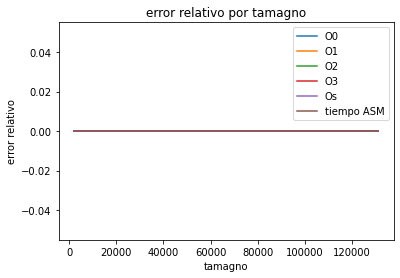

In [14]:
plt.plot(sizes, eo0, label='O0')
plt.plot(sizes, eo1, label='O1')
plt.plot(sizes, eo2, label='O2')
plt.plot(sizes, eo3, label='O3')
plt.plot(sizes, eos, label='Os')
plt.plot(sizes, easm, label='tiempo ASM')
plt.title('error relativo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('error relativo')
plt.legend()
plt.show()

In [15]:
# luego de comprobar que todas las funciones son precisas
# se pueden realizar mediciones de tiempo para cada tamagno

t0i = []
t1i = []
t2i = []
t3i = []
tsi = []
tasmi = []

for i, size in enumerate(sizes):
    t0i = []
    t1i = []
    t2i = []
    t3i = []
    tsi = []
    tasmi = []
    for j in range(veces):
        # entradas
        x = numpy.random.rand(size,1).astype(numpy.float32)
        y = numpy.random.rand(size,1).astype(numpy.float32)
    
        # salida
        z =  numpy.zeros((size,1),dtype=numpy.float32)
    
        # tiempo O0
        t = time.time()
        cvfaddO0(x,y,z,size)
        t0i.append(time.time() - t)
        
        # tiempo O1
        t = time.time()
        cvfaddO1(x,y,z,size)
        t1i.append(time.time() - t)
        
        # tiempo O2
        t = time.time()
        cvfaddO2(x,y,z,size)
        t2i.append(time.time() - t)
        
        # tiempo O3
        t = time.time()
        cvfaddO3(x,y,z,size)
        t3i.append(time.time() - t)
        
        # tiempo Os
        t = time.time()
        cvfaddOs(x,y,z,size)
        tsi.append(time.time() - t)
    
        # tiempo ASM
        t = time.time()
        cvfaddasm(x,y,z,size)
        tasmi.append(time.time() - t)
        
    to0[i] = statistics.mean(filtro_mediana(t0i,7))
    to1[i] = statistics.mean(filtro_mediana(t1i,7))
    to2[i] = statistics.mean(filtro_mediana(t2i,7))
    to3[i] = statistics.mean(filtro_mediana(t3i,7))
    tos[i] = statistics.mean(filtro_mediana(tsi,7))
    tasm[i] = statistics.mean(filtro_mediana(tasmi,7))

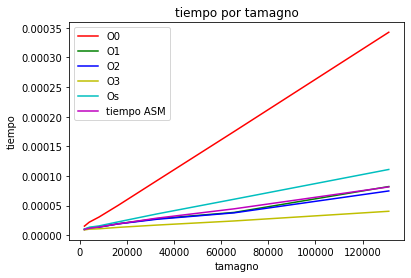

In [16]:
plt.plot(sizes, to0, 'r', label='O0')
plt.plot(sizes, to1, 'g', label='O1')
plt.plot(sizes, to2, 'b', label='O2')
plt.plot(sizes, to3, 'y', label='O3')
plt.plot(sizes, tos, 'c', label='Os')
plt.plot(sizes, tasm, 'm', label='tiempo ASM')
plt.title('tiempo por tamagno')
plt.xlabel('tamagno')
plt.ylabel('tiempo')
plt.legend()
plt.show()

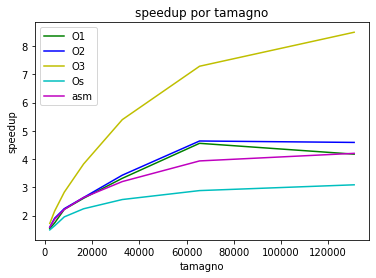

In [17]:
plt.plot(sizes, to0/to1, 'g', label='O1')
plt.plot(sizes, to0/to2, 'b', label='O2')
plt.plot(sizes, to0/to3, 'y', label='O3')
plt.plot(sizes, to0/tos, 'c', label='Os')
plt.plot(sizes, to0/tasm, 'm', label='asm')
plt.title('speedup por tamagno')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()

In [18]:
! rm *.o
! rm *.so
! rm *.asm
! rm *.c